# HUC8 Streamflow Aggregation Query

This notebook shows how to get a HUC8 by id, query NHD for all reaches within the HUC, and then query the NWM reanalysis dataset to get aggregated streamflow values.

Note: this is a work in progress. See TODOs.

# Setup

In [1]:
import json

import psycopg2
import shapely
import shapely.wkt
import geopandas as gpd
import xarray as xr
import fsspec
import numpy as np
import pyproj

%matplotlib inline

In [2]:
def get_cursor(database):
    connection = psycopg2.connect(host="noaa-db", database=database,user="postgres", password="mysecretpassword")
    cursor = connection.cursor()
    return cursor

# Use NHD to get a HUC and reaches around Cobb's Creek in West Philly

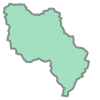

In [3]:
# TODO instead of using database, use HUC8 extracts on S3 to do query for a few HUC8s.

# Get HUC by id

# Use NHDPlus HR because it has HUC boundaries
cursor = get_cursor('nhdplushr')
huc12 = '020402020504'
query = "SELECT wkb_geometry from wbdhu12 WHERE huc12=%s"
cursor.execute(query, [huc12])
huc_geom = shapely.wkb.loads(cursor.fetchone()[0].tobytes())
huc_geom

In [4]:
# Get reaches that intersect the HUC
# Note that only NHDv2 (and apparently not NHDPlus HR) has the ComId field which is 
# used to index reaches in NWM as the feature_id.
cursor = get_cursor('nhdplusv2')
query = f'''
    SELECT comid, wkb_geometry from nhdflowline WHERE ST_Intersects(
        ST_GeomFromWKB(wkb_geometry, 4326), ST_GeomFromGeoJSON(%s))
    '''

huc_geom_str = json.dumps(shapely.geometry.mapping(huc_geom))
cursor.execute(query, [huc_geom_str])
reach_geoms = []
reach_ids = []
for reach_id, reach_geom in cursor:
    reach_ids.append(reach_id)
    reach_geoms.append(shapely.wkb.loads(reach_geom.tobytes()))

<AxesSubplot:>

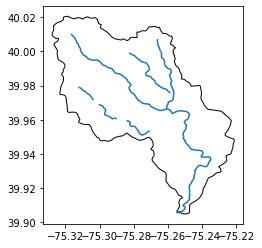

In [8]:
# Plot the HUC and reaches.
# It's strange that some of the reach segments seem to be missing.
# Question: why is that?
df = gpd.GeoDataFrame({'geometry': reach_geoms + [huc_geom]})
df.plot(facecolor="none")

# Query NWM by reach ids

In [6]:
# Load the CHRTOUT data from the NWM Retrospective Zarr 2.1 dataset
# This has "Streamflow values at points associated with flow lines" 
# See https://registry.opendata.aws/nwm-archive/
nwm_uri = 's3://noaa-nwm-retrospective-2-1-zarr-pds/chrtout.zarr'
ds = xr.open_zarr(fsspec.get_mapper(nwm_uri, anon=True, requester_pays=True))
ds

<xarray.Dataset>
Dimensions:     (feature_id: 2776738, time: 367439)
Coordinates:
    elevation   (feature_id) float32 dask.array<chunksize=(2776738,), meta=np.ndarray>
  * feature_id  (feature_id) int32 101 179 181 ... 1180001803 1180001804
    gage_id     (feature_id) |S15 dask.array<chunksize=(2776738,), meta=np.ndarray>
    latitude    (feature_id) float32 dask.array<chunksize=(2776738,), meta=np.ndarray>
    longitude   (feature_id) float32 dask.array<chunksize=(2776738,), meta=np.ndarray>
    order       (feature_id) int32 dask.array<chunksize=(2776738,), meta=np.ndarray>
  * time        (time) datetime64[ns] 1979-02-01T01:00:00 ... 2020-12-31T23:0...
Data variables:
    crs         |S1 ...
    streamflow  (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
    velocity    (time, feature_id) float64 dask.array<chunksize=(672, 30000), meta=np.ndarray>
Attributes:
    TITLE:                OUTPUT FROM WRF-Hydro v5.2.0-beta2
    code_version:         v5.2.0-beta2
    featureType:          timeSeries
    model_configuration:  retrospective
    proj4:                +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1...

In [9]:
# Note that the chunks are 2D as opposed to whole rows or whole columns.
ds.streamflow

<xarray.DataArray 'streamflow' (time: 367439, feature_id: 2776738)>
dask.array<open_dataset-480c722a362dbf33f33b30ff49bbf3f8streamflow, shape=(367439, 2776738), dtype=float64, chunksize=(672, 30000), chunktype=numpy.ndarray>
Coordinates:
    elevation   (feature_id) float32 dask.array<chunksize=(2776738,), meta=np.ndarray>
  * feature_id  (feature_id) int32 101 179 181 ... 1180001803 1180001804
    gage_id     (feature_id) |S15 dask.array<chunksize=(2776738,), meta=np.ndarray>
    latitude    (feature_id) float32 dask.array<chunksize=(2776738,), meta=np.ndarray>
    longitude   (feature_id) float32 dask.array<chunksize=(2776738,), meta=np.ndarray>
    order       (feature_id) int32 dask.array<chunksize=(2776738,), meta=np.ndarray>
  * time        (time) datetime64[ns] 1979-02-01T01:00:00 ... 2020-12-31T23:0...
Attributes:
    grid_mapping:  crs
    long_name:     River Flow
    units:         m3 s-1

In [10]:
# Queries can be seen as lying on a spectrum that ranges from "a single time step and all features" to "all time steps and one feature."
# This is to get an idea how the current chunking pattern supports these extremes.
shape = np.array(ds.streamflow.shape)
chunk_sizes = np.array([ds.streamflow.chunks[0][0], ds.streamflow.chunks[1][0]])
nb_chunks = shape // chunk_sizes
gb_per_chunk = (chunk_sizes.prod() * 8) / (10 ** 9)

print(f'The number of chunks for each dimension: {nb_chunks}')
print(f'For a whole time series and single feature: {nb_chunks[0]} chunks, and {nb_chunks[0] * gb_per_chunk :.1f} GB')
print(f'For a single time step and all features: {nb_chunks[1]} chunks, and {nb_chunks[1] * gb_per_chunk :.1f} GB')

The number of chunks for each dimension: [546  92]
For a whole time series and single feature: 546 chunks, and 88.1 GB
For a single time step and all features: 92 chunks, and 14.8 GB


In [11]:
# Apparently, only some of the reach ids in NHDPlus V2 are available in NWM.
# Question: why is that?
avail_reach_ids = list(set(ds.feature_id.values).intersection(set(reach_ids)))
print(
    f'There are {len(reach_ids)} reaches in the HUC and {len(avail_reach_ids)} of those are in NWM.')

There are 10 reaches in the HUC and 6 of those are in NWM.


In [12]:
# Perform the query: lazily compute the subset of the dataset that contains the reaches for a time range.
sub_ds = ds.sel(feature_id=avail_reach_ids, time=slice('1979-02-01', '1979-02-15'))
sub_ds

<xarray.Dataset>
Dimensions:     (feature_id: 6, time: 359)
Coordinates:
    elevation   (feature_id) float32 dask.array<chunksize=(6,), meta=np.ndarray>
  * feature_id  (feature_id) int32 4495680 4495656 4494480 ... 4489138 4496602
    gage_id     (feature_id) |S15 dask.array<chunksize=(6,), meta=np.ndarray>
    latitude    (feature_id) float32 dask.array<chunksize=(6,), meta=np.ndarray>
    longitude   (feature_id) float32 dask.array<chunksize=(6,), meta=np.ndarray>
    order       (feature_id) int32 dask.array<chunksize=(6,), meta=np.ndarray>
  * time        (time) datetime64[ns] 1979-02-01T01:00:00 ... 1979-02-15T23:0...
Data variables:
    crs         |S1 ...
    streamflow  (time, feature_id) float64 dask.array<chunksize=(359, 6), meta=np.ndarray>
    velocity    (time, feature_id) float64 dask.array<chunksize=(359, 6), meta=np.ndarray>
Attributes:
    TITLE:                OUTPUT FROM WRF-Hydro v5.2.0-beta2
    code_version:         v5.2.0-beta2
    featureType:          timeSeries
    model_configuration:  retrospective
    proj4:                +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1...

In [13]:
%%time

# Actually get the streamflow values.
vals = sub_ds.streamflow.values
vals.shape

CPU times: user 3.11 s, sys: 328 ms, total: 3.43 s
Wall time: 7.91 s


(359, 6)

In [14]:
%%time

# Compute mean for each day.
vals = sub_ds.streamflow.groupby('time.dayofyear').mean().values
vals.shape

CPU times: user 3.21 s, sys: 276 ms, total: 3.49 s
Wall time: 7.99 s


(15, 6)